#Analisis de datos Whatsapp

In [21]:
!pip install pandas
!pip install requests
!pip install emoji

In [22]:
import pandas as pd
import re
import requests

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px

import regex
import emoji
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Personal/WhatsApp_Analisis/
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Personal/WhatsApp_Analisis
estudio.txt  MANS.txt  peluquero.txt  WhatsApp_Analisis.ipynb




*   Pasar chats de .txt a tipo de datos tabulares (tablas)



In [20]:
#Open main directory
file_path = 'peluquero.txt'

In [24]:
def parse_line(line):
    # Analizar cada línea del archivo y separar en fecha, hora, Miembro y mensaje
    pattern = re.compile(r'^(\d+/\d+/\d+, \d+:\d+) - ([^:]+): (.+)$')
    match = pattern.match(line)

    if match:
        fecha_hora = match.group(1)
        Miembro = match.group(2)
        mensaje = match.group(3)

        return fecha_hora, Miembro, mensaje
    else:
        return None

def parse_line_continuation(lines):
    # Unir las líneas y analizar el mensaje completo
    joined_line = ' '.join(lines)
    return parse_line(joined_line)

# Lista para almacenar los datos (Fecha, Hora, Miembro, Mensaje) de cada línea del txt
datos_lista = []

with open(file_path, encoding="utf-8") as fp:
    #fp.readline() # Eliminar primera fila relacionada al cifrado de extremo a extremo
    lines_buffer = []

    while True:
        linea = fp.readline()

        if not linea:
            break

        linea = linea.strip()

        if not linea:  # Ignorar líneas en blanco
            continue

        # Verificar si la línea actual completa un mensaje
        parsed_data = parse_line(linea)

        if parsed_data:
            fecha_hora, Miembro, mensaje = parsed_data
            datos_lista.append([fecha_hora, Miembro, mensaje])
            lines_buffer = []  # Limpiar el buffer después de procesar un mensaje
        else:
            # Agregar la línea al buffer
            lines_buffer.append(linea)

# Convertir la lista con los datos a DataFrame
df = pd.DataFrame(datos_lista, columns=['Fecha_Hora', 'Miembro', 'Mensaje'])

# Dividir la columna Fecha_Hora en columnas separadas de Fecha y Hora
df[['Fecha', 'Hora']] = df['Fecha_Hora'].str.split(', ', expand=True)

# Cambiar la columna Fecha a formato datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format="%d/%m/%y")

# Eliminar la columna Fecha_Hora
df.drop(columns=['Fecha_Hora'], inplace=True)

# Eliminar filas con valores nulos
df = df.dropna()

# Reorganizar las columnas
df = df[['Fecha', 'Hora', 'Miembro', 'Mensaje']]

# Mostrar el DataFrame
df


,Fecha,Hora,Miembro,Mensaje
0,2016-09-13,16:50,Doriaπ,Hola tio hoy puedes recortar?
1,2016-09-13,16:50,jorge,Si tt puedes en 30 min?
2,2016-09-13,16:51,Doriaπ,vale
3,2016-09-13,16:51,Doriaπ,ire con el surfero
4,2016-09-13,16:51,Doriaπ,que tambien queria cortarse
...,...,...,...,...
2391,2023-12-19,23:32,jorge,Tt perdona vente 19:30 mejor el jueves🙏🏽 perdona
2392,2023-12-19,23:39,Doriaπ,si te va bien esta hora tmb puedo tt
2393,2023-12-19,23:40,Doriaπ,"si no, sin problemas a esta mismop"
2394,2023-12-20,1:17,jorge,esta mejor tt ya la otra esta pillada


#Estadisticas del conjunto grupal

In [25]:
def ObtenerEmojis(Mensaje):
    emoji_lista = []
    data = regex.findall(r'\X', Mensaje) # Obtener lista de caracteres de cada mensaje
    for caracter in data:
        if caracter in emoji.EMOJI_DATA: # Obtener emojis en idioma español
            emoji_lista.append(caracter)
    return emoji_lista

# Obtener la cantidad total de mensajes
total_mensajes = df.shape[0]

# Obtener la cantidad de archivos multimedia enviados
multimedia_mensajes = df[df['Mensaje'] == '<Multimedia omitido>'].shape[0]

# Obtener la cantidad de emojis enviados
df['Emojis'] = df['Mensaje'].apply(ObtenerEmojis) # Se agrega columna 'Emojis'
emojis = sum(df['Emojis'].str.len())

# Obtener la cantidad de links enviados
url_patron = r'(https?://\S+)'
df['URLs'] = df.Mensaje.apply(lambda x: len(re.findall(url_patron, x))) # Se agrega columna 'URLs'
links = sum(df['URLs'])

# Obtener la cantidad de encuestas
encuestas = df[df['Mensaje'] == 'ENCUESTA:'].shape[0]

# Obtener la cantidad de mensajes eliminados
msg_delete = df[df['Mensaje'] == 'Se eliminó este mensaje.'].shape[0]

# Todos los datos pasarlo a diccionario
estadistica_dict = {'Tipo': ['Mensajes', 'Multimedia', 'Emojis', 'Links', 'Mensajes eliminados', 'Encuestas'],
        'Cantidad': [total_mensajes, multimedia_mensajes, emojis, links, msg_delete, encuestas]
        }

#Convertir diccionario a dataframe
estadistica_df = pd.DataFrame(estadistica_dict, columns = ['Tipo', 'Cantidad'])

# Establecer la columna Tipo como índice
estadistica_df = estadistica_df.set_index('Tipo')
estadistica_df

,Cantidad
Tipo,
Mensajes,2396
Multimedia,137
Emojis,128
Links,45
Mensajes eliminados,6
Encuestas,0


In [26]:
# Obtener emojis más usados y las cantidades en el chat del grupo del dataframe
emojis_lista = list([a for b in df.Emojis for a in b])
emoji_diccionario = dict(Counter(emojis_lista))
emoji_diccionario = sorted(emoji_diccionario.items(), key=lambda x: x[1], reverse=True)

# Convertir el diccionario a dataframe
emoji_df = pd.DataFrame(emoji_diccionario, columns=['Emoji', 'Cantidad'])

# Establecer la columna Emoji como índice
emoji_df = emoji_df.set_index('Emoji')

print('Número emojis únicos usados: ', len(emoji_df), '\n')
emoji_df.head(15)

Número emojis únicos usados:  32 



,Cantidad
Emoji,
😂,26
🔥,15
❤️,8
💈,8
🤔,7
🙌🏽,7
🙏🏽,6
🙇🏽,4
🥺,4


In [27]:
# Plotear el pie de los emojis más usados
fig = px.pie(emoji_df, values='Cantidad', names=emoji_df.index, title='Pie de emojis')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

#Estadisticas de cada miembro del grupo

In [28]:
#Sacamos los miembros del grupo.
df.Miembro.unique()

array(['Doriaπ', 'jorge'], dtype=object)

In [29]:
# Determinar los miembros más activos del grupo
df_MiembrosActivos = df.groupby('Miembro')['Mensaje'].count().sort_values(ascending=False).to_frame()
df_MiembrosActivos.reset_index(inplace=True)
df_MiembrosActivos.index = np.arange(1, len(df_MiembrosActivos)+1)
df_MiembrosActivos

,Miembro,Mensaje
1,Doriaπ,1328
2,jorge,1068


In [30]:
# Separar mensajes (sin multimedia) y multimedia (stickers, fotos, videos)
multimedia_df = df[df['Mensaje'] == '<Multimedia omitido>']
mensajes_df = df.drop(multimedia_df.index)

# Contar la cantidad de palabras y letras por mensaje
mensajes_df['Letras'] = mensajes_df['Mensaje'].apply(lambda s : len(s))
mensajes_df['Palabras'] = mensajes_df['Mensaje'].apply(lambda s : len(s.split(' ')))

In [31]:
# Obtener a todos los miembros
miembros = mensajes_df.Miembro.unique()

# Crear diccionario donde se almacenará todos los datos
dictionario = {}

for i in range(len(miembros)):
  lista = []
  # Filtrar mensajes de un miembro en específico
  miembro_df= mensajes_df[mensajes_df['Miembro'] == miembros[i]]

  # Agregar a la lista el número total de mensajes enviados
  lista.append(miembro_df.shape[0])

  # Agregar a la lista el número de palabras por total de mensajes (palabras por mensaje)
  palabras_por_msj = (np.sum(miembro_df['Palabras']))/miembro_df.shape[0]
  lista.append(palabras_por_msj )

  # Agregar a la lista el número de mensajes multimedia enviados
  multimedia = multimedia_df[multimedia_df['Miembro'] == miembros[i]].shape[0]
  lista.append(multimedia)

  # Agregar a la lista el número total de emojis enviados
  emojis = sum(miembro_df['Emojis'].str.len())
  lista.append(emojis)

  # Agregar a la lista el número total de links enviados
  links = sum(miembro_df['URLs'])
  lista.append(links)

  # Asignar la lista como valor a la llave del diccionario
  dictionario[miembros[i]] = lista
print(dictionario)

{'Doriaπ': [1305, 5.749425287356321, 23, 20, 28], 'jorge': [954, 4.69706498951782, 114, 108, 17]}


In [32]:
# Convertir de diccionario a dataframe
miembro_stats_df = pd.DataFrame.from_dict(dictionario)

# Cambiar el índice por la columna agregada 'Estadísticas'
estadísticas = ['Mensajes', 'Palabras por mensaje', 'Multimedia', 'Emojis', 'Links']
miembro_stats_df['Estadísticas'] = estadísticas
miembro_stats_df.set_index('Estadísticas', inplace=True)

# Transponer el dataframe
miembro_stats_df = miembro_stats_df.T

#Convertir a integer las columnas Mensajes, Multimedia Emojis y Links
miembro_stats_df['Mensajes(no multimedia)'] = miembro_stats_df['Mensajes'].apply(int)
miembro_stats_df['Multimedia'] = miembro_stats_df['Multimedia'].apply(int)
miembro_stats_df['Emojis'] = miembro_stats_df['Emojis'].apply(int)
miembro_stats_df['Links'] = miembro_stats_df['Links'].apply(int)
miembro_stats_df.head(12)

Estadísticas,Mensajes,Palabras por mensaje,Multimedia,Emojis,Links,Mensajes(no multimedia)
Doriaπ,1305.0,5.749425,23,20,28,1305
jorge,954.0,4.697065,114,108,17,954


#Estadisticas del comportamiento

In [33]:
df['rangoHora'] = pd.to_datetime(df['Hora'], format='%H:%M')

# Define a function to create the "Range Hour" column
def create_range_hour(hour):
    start_hour = hour.hour
    end_hour = (hour + pd.Timedelta(hours=1)).hour
    return f'{start_hour:02d} - {end_hour:02d} h'

# Apply the function to create the "Range Hour" column
df['rangoHora'] = df['rangoHora'].apply(create_range_hour)

In [34]:
# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por hora'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
date_df = df.groupby('rangoHora').sum()
date_df.reset_index(inplace=True)

# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(date_df, x='rangoHora', y='# Mensajes por hora')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Media de mensajes (y) en intervalos de tiempo (x)',
             'y':0.96,
             'x':0.5,
             'xanchor': 'center'},
    font=dict(size=15))
fig.update_xaxes(title_text='Rango de hora', tickangle=30)
fig.update_yaxes(title_text='# Mensajes')
fig.show()

<ipython-input-34-dc9a728fe96f>:5: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [35]:
# Crear una columna de 1 para realizar el conteo de mensajes
df['# Mensajes por día'] = 1

# Sumar (contar) los mensajes que tengan la misma fecha
date_df = df.groupby('Fecha').sum()
date_df.reset_index(inplace=True)

# Plotear la cantidad de mensajes respecto del tiempo
fig = px.line(date_df, x='Fecha', y='# Mensajes por día')

# Ajustar el gráfico
fig.update_layout(
    title={'text': 'Días con más mensajes',
             'y':0.96,
             'x':0.5,
             'xanchor': 'center'},
    font=dict(size=15))
fig.update_xaxes(title_text='Fecha', tickangle=45, nticks=35)
fig.update_yaxes(title_text='# Mensajes')
fig.show()

<ipython-input-35-583c17abffba>:5: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



Text(0.5, 1.0, 'Word Cloud (palabras más usadas)')

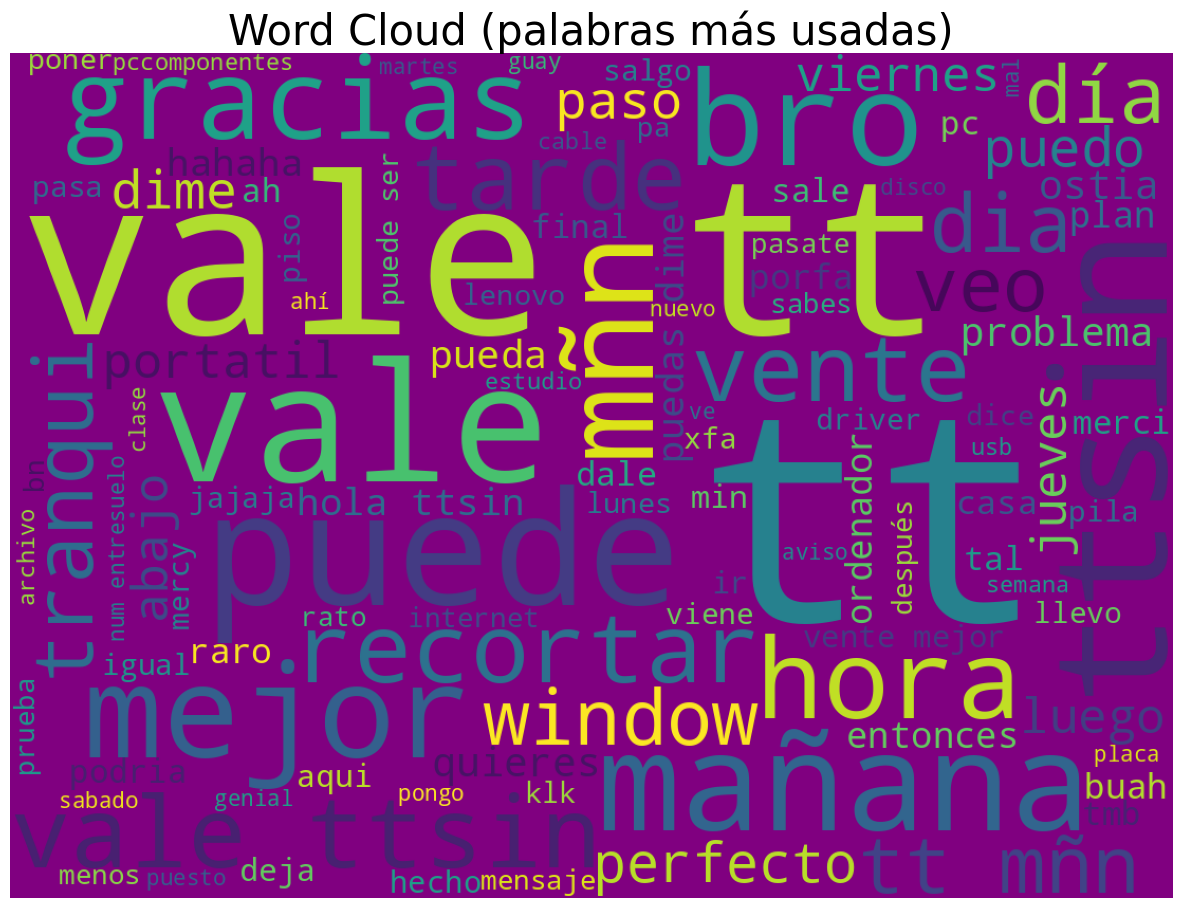

In [36]:
# Crear un string que contendrá todas las palabras
total_palabras = ' '

stop_words_nltk = set(nltk_stopwords.words('spanish'))
stemmer = nltk.stem.SnowballStemmer('spanish')

STOPWORDS.update(['que', 'qué', 'con', 'de', 'te', 'en', 'la', 'lo', 'le', 'el', 'las', 'los', 'les', 'por', 'es',
                              'son', 'se', 'para', 'un', 'una', 'chicos', 'su', 'si', 'chic','nos', 'ya', 'hay', 'esta',
                              'pero', 'del', 'mas', 'más', 'eso', 'este', 'como', 'así', 'todo', 'https','Media','omitted',
                              'y', 'mi', 'o', 'q', 'yo', 'al', 'xq', 'asi', 'aún', 'porq', 'pue', 'pues','xd', 'sé', 'bueno', 'va', 'creo','cosa', 'cosas','ahora','jajajajaja', 'hacer','jajajaja','tío','tio',
                              'jajajajajaja','jajajajajajaja', 'eh', 'voy','ver','@34608958469','vaya','hoy', 'solo', 'bien', 'jajajajajajajaja'])

stop_words_perso = set(STOPWORDS)

stop_words = stop_words_nltk.union(stop_words_perso)

# Obtener y acumular todas las palabras de cada mensaje
for mensaje in mensajes_df['Mensaje'].values:
    palabras = str(mensaje).lower().split() # Obtener las palabras de cada línea del txt
    for palabra in palabras:
        total_palabras = total_palabras + palabra + ' ' # Acumular todas las palabras

plt.figure(figsize=(15, 15))
wordcloud = WordCloud(width=1100,
                height=800,
                background_color ='purple',
                stopwords = stop_words,
                min_font_size = 15).generate(total_palabras)

# Plotear la nube de palabras más usadas
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud (palabras más usadas)', fontsize=30)

tt: 645
vale: 374
ttsin: 155
mñn: 92
mejor: 76
puedes: 73
mañana: 62
bro: 61
hora: 61
vente: 60
gracias: 59
dime: 47
recortar: 40
puedas: 39
tarde: 34


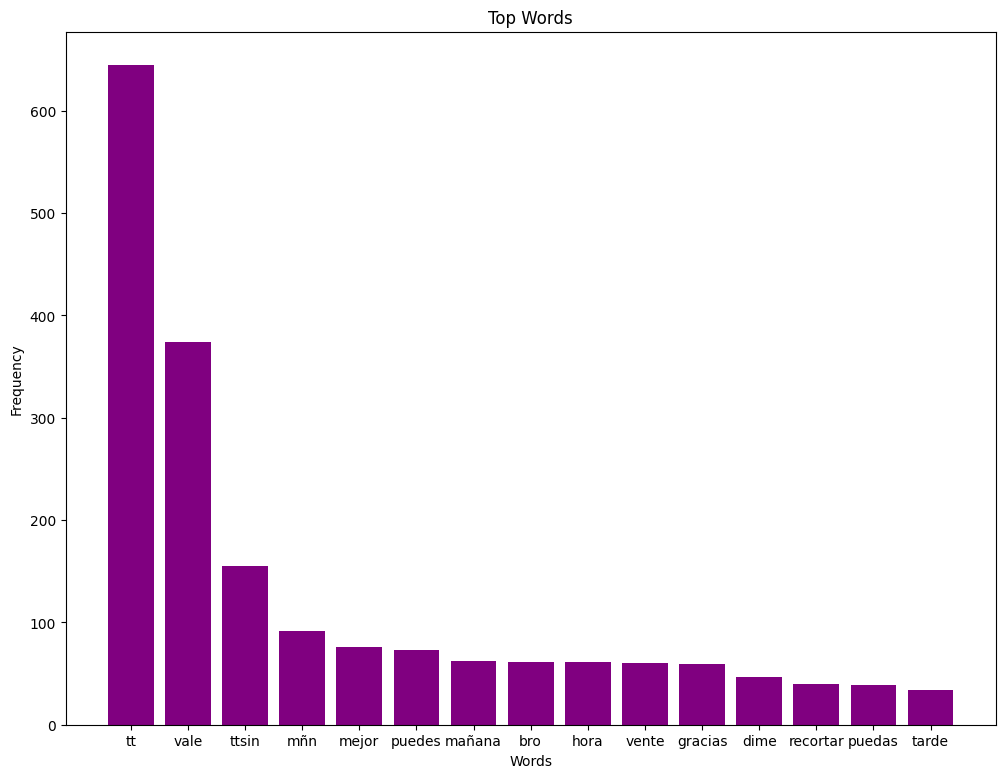

In [37]:
# Split all words in the total_palabras string
all_words = total_palabras.lower().split()

# Remove stop words from the list of all words
filtered_words = [word for word in all_words if word not in stop_words]

# Count the frequency of each word
word_counts = Counter(filtered_words)

# Get the most common words and their counts
most_common_words = word_counts.most_common(15)  # Change 10 to the desired number of top words

# Print or use the most common words
for word, count in most_common_words:
    print(f"{word}: {count}")

# If you want to plot a bar chart for the most common words
import matplotlib.pyplot as plt

words, counts = zip(*most_common_words)
plt.figure(figsize=(12, 9))
plt.bar(words, counts, color='purple')
plt.title('Top Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()
